In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from scipy.linalg import sqrtm
from sklearn.utils import shuffle
import os

# Set GPU memory growth to avoid OOM errors


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define the generator model

In [3]:

def build_generator(latent_dim, num_classes):
    model_input = layers.Input(shape=(latent_dim,))
    label_input = layers.Input(shape=(num_classes,))

    x = layers.Concatenate()([model_input, label_input])
    x = layers.Dense(128 * 8 * 8, activation='relu')(x)
    x = layers.Reshape((8, 8, 128))(x)
    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(3, kernel_size=5, padding='same', activation='sigmoid')(x)

    generator = models.Model([model_input, label_input], x)
    return generator



# Define the discriminator model

In [4]:

def build_discriminator(img_shape, num_classes):
    model_input = layers.Input(shape=img_shape)
    label_input = layers.Input(shape=(num_classes,))

    x = layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu')(model_input)
    x = layers.Conv2D(128, kernel_size=5, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=5, strides=2, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, label_input])
    x = layers.Dense(1, activation='sigmoid')(x)

    discriminator = models.Model([model_input, label_input], x)
    return discriminator



# Define the CGAN model

In [5]:

def build_cgan(generator, discriminator):
    model_input = layers.Input(shape=(latent_dim,))
    label_input = layers.Input(shape=(num_classes,))

    generated_image = generator([model_input, label_input])
    cgan_output = discriminator([generated_image, label_input])

    cgan = models.Model([model_input, label_input], cgan_output)
    return cgan

# Wasserstein loss function for improved stability
def wasserstein_loss(y_true, y_pred):
    return -tf.reduce_mean(y_true * y_pred)

# Gradient penalty for Wasserstein GAN with gradient penalty (WGAN-GP)
def gradient_penalty(f, real, fake):
    alpha = tf.random.uniform([real.shape[0], 1, 1, 1], 0.0, 1.0)
    interpolated = alpha * real + (1 - alpha) * fake
    with tf.GradientTape() as t:
        t.watch(interpolated)
        pred = f(interpolated)
    grad = t.gradient(pred, interpolated)
    norm = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=[1, 2, 3]))
    return tf.reduce_mean(tf.square(norm - 1.0))

# Load and preprocess the dataset

In [6]:

batch_size = 32
latent_dim = 100
num_classes = 6
img_shape = (64, 64, 3)

# Load images using ImageDataGenerator from Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
    "dataset/",
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 15453 images belonging to 6 classes.


# Create generator, discriminator, and cgan


In [7]:
generator = build_generator(latent_dim, num_classes)
discriminator = build_discriminator(img_shape, num_classes)
cgan = build_cgan(generator, discriminator)

# Compile models
discriminator.compile(optimizer=optimizers.Adam(lr=0.0002, beta_1=0.5), loss=wasserstein_loss)
cgan.compile(optimizer=optimizers.Adam(lr=0.0002, beta_1=0.5), loss=wasserstein_loss)


#train

In [8]:
# Training loop
epochs = 10
g1 = 50

# steps_per_epoch = len(train_generator)
steps_per_epoch = g1

for step in range(steps_per_epoch):
    # Train discriminator
    real_images, labels = train_generator.next()
    real_labels = np.argmax(labels, axis=1)  # Convert one-hot encoded labels to integer labels
    real_images = (real_images - 0.5) * 2  # Rescale images to [-1, 1]

    fake_labels = np.random.randint(0, num_classes, batch_size)
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_images = generator.predict([noise, tf.keras.utils.to_categorical(fake_labels, num_classes)])

    discriminator.trainable = True
    d_loss_real = discriminator.train_on_batch([real_images, tf.keras.utils.to_categorical(real_labels, num_classes)], -np.ones(batch_size))
    d_loss_fake = discriminator.train_on_batch([fake_images, tf.keras.utils.to_categorical(fake_labels, num_classes)], np.ones(batch_size))
    gradient_loss = gradient_penalty(lambda x: discriminator([x, tf.keras.utils.to_categorical(fake_labels, num_classes)]), real_images, fake_images)
    d_loss = d_loss_fake + d_loss_real + gradient_loss

    # Train generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_labels = np.random.randint(0, num_classes, batch_size)
    discriminator.trainable = False
    g_loss = cgan.train_on_batch([noise, tf.keras.utils.to_categorical(fake_labels, num_classes)], -np.ones(batch_size))

    if step % 100 == 0:
        print(f'Step {step}/{steps_per_epoch} | D Loss: {d_loss} | G Loss: {g_loss}')


1/1 [==============================] - 0s 354ms/step



Step 0/50 | D Loss: 1.4181650876998901 | G Loss: 0.30660220980644226
1/1 [==============================] - 0s 153ms/step


#generate faces

1/1 [==============================] - 0s 120ms/step


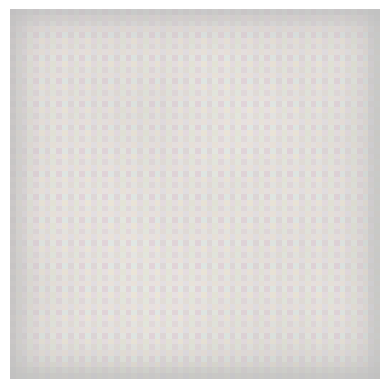

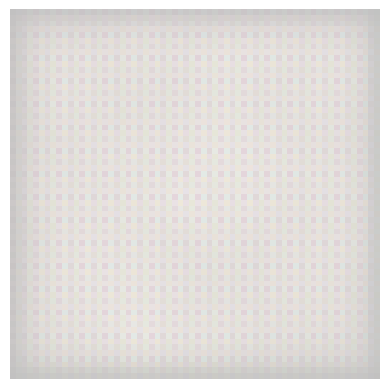

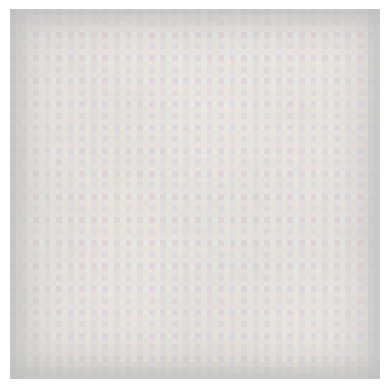

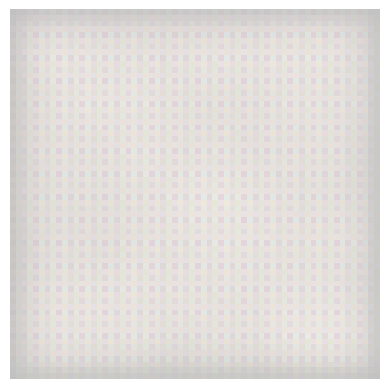

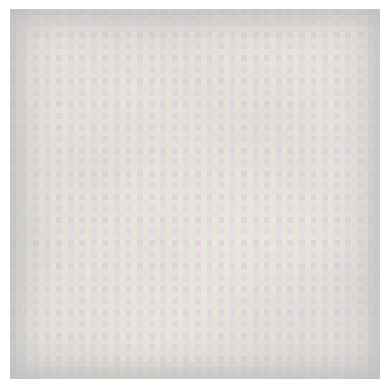

In [9]:
import matplotlib.pyplot as plt

def generate_samples(generator, num_samples):
    os.makedirs('generated_samples', exist_ok=True)
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    labels = np.random.randint(0, num_classes, num_samples)
    generated_images = generator.predict([noise, tf.keras.utils.to_categorical(labels, num_classes)])

    for i in range(num_samples):
        image = generated_images[i]
        image = (image + 1) / 2
        plt.imshow(image)
        plt.axis('off')
        plt.savefig(f'generated_samples/generated_image_{i}.png')
        plt.show()

generate_samples(generator, num_samples=5)


In [10]:
generator.save('GanGenerator.h5')

C:\Users\Owner\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
import cv2
cv2.__version__

'4.7.0'